Basic idea is to run trajectory optimization from a number of samples (simultaneously), constraining the inputs to be a simple function of the output (the output feedback policy).

E.g.  Given $$\dot{x} = f(x,u), y = h(x,u).$$ 

\begin{gather*}
\min_{x(\cdot),u(\cdot),K}  \quad \int g(x,u) dt, \\
\text{subject to} \quad \dot{x} = f(x,u), \quad u = K h(x,u)
\end{gather*}

In [13]:
import math
import numpy as np
%matplotlib notebook  
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


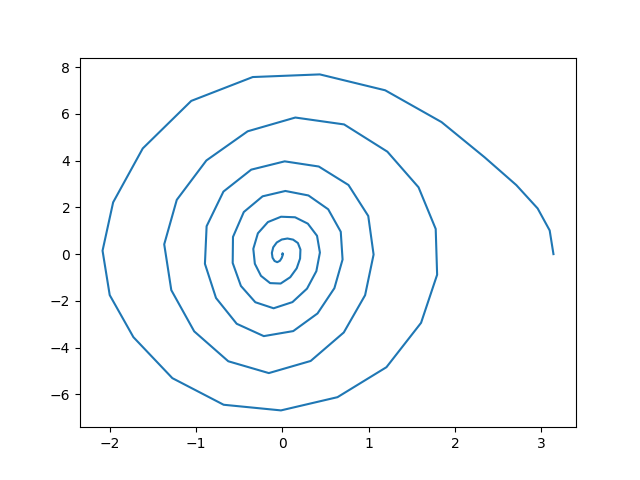

In [5]:
from pydrake.examples.pendulum import (PendulumPlant, PendulumState)
from pydrake.all import ( DirectCollocation, PiecewisePolynomial, SolutionResult )

plant = PendulumPlant()
context = plant.CreateDefaultContext()

kNumTimeSamples = 21
kMinimumTimeStep = 0.2
kMaximumTimeStep = 0.5

dircol = DirectCollocation(plant, context, kNumTimeSamples, kMinimumTimeStep, kMaximumTimeStep)

dircol.AddEqualTimeIntervalsConstraints()

kTorqueLimit = 3.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-kTorqueLimit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= kTorqueLimit)

initial_state = PendulumState()
initial_state.set_theta(0.0)
initial_state.set_thetadot(0.0)
dircol.AddBoundingBoxConstraint(initial_state.get_value(), initial_state.get_value(), dircol.initial_state())
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state.get_value())

final_state = PendulumState()
final_state.set_theta(math.pi)
final_state.set_thetadot(0.0)
dircol.AddBoundingBoxConstraint(final_state.get_value(), final_state.get_value(), dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

R = 10  # Cost on input "effort".
dircol.AddRunningCost(R*u[0]**2)

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], [initial_state.get_value(), final_state.get_value()])
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = dircol.Solve()
assert(result == SolutionResult.kSolutionFound)

x_trajectory = dircol.ReconstructStateTrajectory()
x_knots = np.hstack([x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)])

plt.plot(x_knots[0,:], x_knots[1,:])

In [6]:

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
print(x)
print(x[0] == 0.)
print(x==[0.,0.])

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]
(x(0) == 0)


DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.

Does policy search over static linear feedback gains recover the LQR solution for an LQR problem?

In [ ]:
from pydrake.all import MathematicalProgram
from pydrake.all import (DirectTranscription, LinearSystem, LinearQuadraticRegulator, 
                         PiecewisePolynomial, SolutionResult)

A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.identity(2)
R = np.identity(1)

sys = LinearSystem(A,B,np.identity(2),np.zeros((2,1)),0.1)
context = sys.CreateDefaultContext()
kNumTimeSteps = 41  # Note: When this was 21, it converged on a local minima.
prog = DirectTranscription(sys, context, kNumTimeSteps)
K = prog.NewContinuousVariables(1, 2, 'K')
prog.AddConstraintToAllKnotPoints(prog.input()[0] == (-K.dot(prog.state()))[0])
prog.AddRunningCost(prog.state().dot(Q.dot(prog.state())) + prog.input().dot(R.dot(prog.input())))
prog.AddBoundingBoxConstraint([1., 1.], [1., 1.], prog.initial_state())
ret = prog.Solve()
print(prog.GetSolution(K))
x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

K_expected = -LinearQuadraticRegulator(sys, Q, R).D()
print(K_expected)

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

SolutionResult.kIterationLimit
[[-106.36744378  185.31523429  329.02473279   11.50958786  -37.44799858
   115.65574021   15.68841994]]
[<Expression "(-106.36744378033531 + 11.509587859576831 * x0(1,0) + 115.6557402094666 * (x0(1,0) * sin(x0(0,0))) - 37.447998584764385 * (x0(1,0) * cos(x0(0,0))) + 15.688419939620896 * pow(x0(1,0), 3) + 329.02473278949117 * sin(x0(0,0)) + 185.31523429440421 * cos(x0(0,0)))">]


<IPython.core.display.Javascript object>


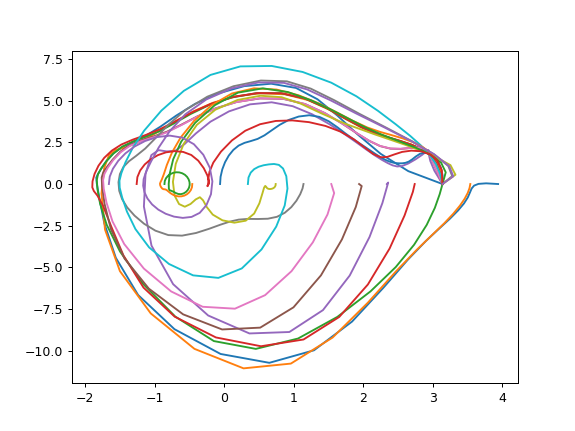

In [16]:
from pydrake.all import (AutoDiffXd, Expression, Variable,
                         MathematicalProgram, SolverType, SolutionResult,
                         DirectCollocationConstraint, AddDirectCollocationConstraint,
                         PiecewisePolynomial,
                        )
import pydrake.symbolic as sym
from pydrake.examples.pendulum import (PendulumPlant)

plant = PendulumPlant()
context = plant.CreateDefaultContext()
dircol_constraint = DirectCollocationConstraint(plant, context)

num_trajectories = 15;
num_samples = 15;
prog = MathematicalProgram()
K = prog.NewContinuousVariables(1,7,'K')

# TODO: Move this into autodiffutils.py
def cos(x):
    if isinstance(x, AutoDiffXd):
        return x.cos()
    elif isinstance(x, Variable):
        return sym.cos(x)
    return math.cos(x)

def sin(x):
    if isinstance(x, AutoDiffXd):
        return x.sin()
    elif isinstance(x, Variable):
        return sym.sin(x)
    return math.sin(x)
    

def control_basis(x):
    return [1, cos(x[0]), sin(x[0]), x[1], x[1]*cos(x[0]), x[1]*sin(x[0]), x[1]**3 ]


def final_cost(x):
    return 100.*(cos(.5*x[0])**2 + x[1]**2)

def control(xuK):
    x = xuK[[0, 1]]
    u = xuK[2]
    K = xuK[3:]
    uc = K.dot(control_basis(x))
    # TODO: snopt doesn't like this.  perhaps a softmax?    
    if (uc.value() > 3.0):
        uc = 3.0
    elif(uc.value() < -3.0):
        uc = -3.0
    return [u - uc]
    
h = [];
u = [];
x = [];
xf = (math.pi, 0.)
for ti in range(num_trajectories):
    h.append(prog.NewContinuousVariables(1))
    prog.AddBoundingBoxConstraint(.01, .2, h[ti])
    u.append(prog.NewContinuousVariables(1, num_samples,'u'+str(ti)))
    x.append(prog.NewContinuousVariables(2, num_samples,'x'+str(ti)))

    x0 = (.8 + math.pi - .4*ti, 0.0)    
    prog.AddBoundingBoxConstraint(x0, x0, x[ti][:,0]) 

    prog.AddBoundingBoxConstraint(xf, xf, x[ti][:,-1])

    for i in range(num_samples-1):
        AddDirectCollocationConstraint(dircol_constraint, h[ti], x[ti][:,i], x[ti][:,i+1], u[ti][:,i], u[ti][:,i+1], prog)

    for i in range(num_samples):
        prog.AddQuadraticCost([1.], [0.], u[ti][:,i])
#        prog.AddConstraint(control, [0.], [0.], np.hstack([x[ti][:,i], u[ti][:,i], K.flatten()]))
#        prog.AddBoundingBoxConstraint([0.], [0.], u[ti][:,i])
        prog.AddConstraint(u[ti][0,i] == (3.*sym.tanh(K.dot(control_basis(x[ti][:,i]))[0])))  # u = 3*tanh(K * m(x))
        
#     prog.AddCost(final_cost, x[ti][:,-1])

#prog.SetSolverOption(SolverType.kSnopt, 'Verify level', -1)  # Derivative checking disabled. (otherwise it complains on the saturation)
prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")
result = prog.Solve()
print(result)
print(prog.GetSolution(K))
print(prog.GetSolution(K).dot(control_basis(x[0][:,0])))

#if (result != SolutionResult.kSolutionFound):
#    f = open('/tmp/snopt.out', 'r')
#    print(f.read())
#    f.close()
    
for ti in range(num_trajectories):
    h_sol = prog.GetSolution(h[ti])[0]    
    breaks = [h_sol*i for i in range(num_samples)]
    knots = prog.GetSolution(x[ti])
    x_trajectory = PiecewisePolynomial.Cubic(breaks, knots, False)
    t_samples = np.linspace(breaks[0], breaks[-1], 45)
    x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    plt.plot(x_samples[0,:], x_samples[1,:])

In [ ]:
from pydrake.autodiffutils import AutoDiffXd

x = AutoDiffXd(1, [1., 0.])
y = x/2.


TODO:
- Add barycentric value iteration solution (do I need to implement the finite-horizon version)
- least squares policy iteration?
- couenne?
